<a href="https://colab.research.google.com/github/rferina/ml_foundations_coursework/blob/main/Rachel_Ferina_HW05_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Data Ingestion

In [ ]:
# Mounting the drive
import os
from google.colab import drive


mount_point = '/content/drive'
drive.mount(mount_point)

drive_dir = os.path.join(mount_point, "MyDrive")
drive_dir

Mounted at /content/drive


'/content/drive/MyDrive'

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [ ]:
# Loading the dataset
dataset_file = "cell_samples_filtered.csv"
cell_df = pd.read_csv(os.path.join(drive_dir, dataset_file))
cell_df.columns

Index(['clump_thickness', 'size_uniformity', 'shape_uniformity',
       'margin_adhesion', 'single_epi_size', 'bare_nuclei', 'bland_chromatin',
       'normal_nucleoli', 'mitoses', 'label'],
      dtype='object')

In [ ]:
cell_df.head()

,clump_thickness,size_uniformity,shape_uniformity,margin_adhesion,single_epi_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,label
0,5.081386,1.133867,1.439054,0.859936,2.239671,1.121287,2.522365,0.884865,1.298166,0
1,4.984307,4.247120,3.835201,4.705714,7.162745,10.063937,2.702325,1.925142,0.943395,0
2,3.510384,0.837297,1.090767,0.501552,2.178225,2.082248,3.079598,0.486168,0.282946,0
3,6.072504,7.447277,7.831365,1.425801,3.290563,3.580416,2.999943,6.849757,0.908079,0
4,4.293832,1.375265,0.571756,3.012504,2.287105,1.033410,2.533865,0.830294,0.903499,0


In [ ]:
X_raw = cell_df.loc[:, cell_df.columns!='label']
X_raw = X_raw.values
y = cell_df['label'].values


Part 2: Data Splitting

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=100, random_state=9)

In [ ]:
for dev_idx, tst_idx in sss.split(X_raw, y):
    X_dev_raw = X_raw[dev_idx]
    y_dev = y[dev_idx]
    X_tst_raw = X_raw[tst_idx]
    y_tst = y[tst_idx]


Part 3: Model Optimization

In [ ]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=5)

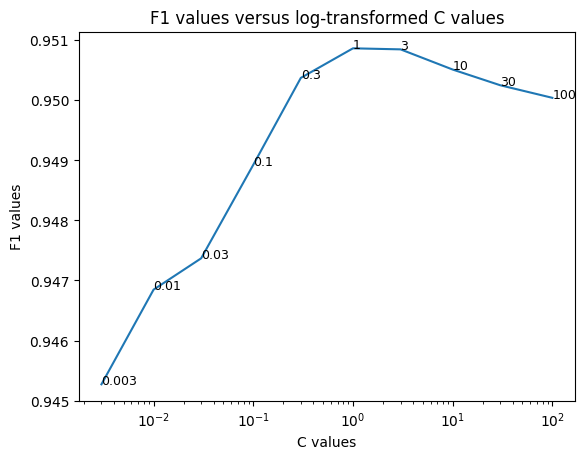

In [ ]:
# create containers for complete y_dev, and y_hat that will accumulate over folds.
# y_hat is our prediction for class label y
y_dev_folds = np.array([])
y_hat_folds = np.array([])

# create holding container for complete F1 over the sampled values of C; and for f1 vs C graph
f1_values = {}
f1_graph = {}

# choose values of C
C_values = [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

# loop over C_values
for C_index, C in enumerate(C_values):
  # loop over folds
  for trn_index, val_index in skf.split(X_dev_raw, y_dev):

    # grab train and val data
    X_trn_raw = X_dev_raw[trn_index]
    X_val_raw = X_dev_raw[val_index]
    y_trn = y_dev[trn_index]
    # rename to y__dev to avoid shape error
    y__dev = y_dev[val_index]

    # standardize data
    X_normalized_trn = StandardScaler().fit_transform(X_trn_raw)
    X_normalized_val = StandardScaler().fit_transform(X_val_raw)

    # instantiate model object
    svm_classifier = svm.SVC(kernel='linear', random_state=42, C=C)

    # train on train data
    svm_classifier.fit(X_normalized_trn, np.ravel(y_trn))

    # evaluate on val data
    # use our test dataset to test our prediction accuracy
    y_hat = svm_classifier.predict(X_normalized_val)

    # accumulate fold data, so we can evaluate over entire development set
    y_dev_folds = np.append(y_dev_folds, y__dev)
    y_hat_folds = np.append(y_hat_folds, y_hat)

  # done with loop over folds
  # compute f1 score over accumulated dev data for this value of C
  f1_values[C_index] = f1_score(y_dev_folds, y_hat_folds)
  f1_graph[C] = f1_score(y_dev_folds, y_hat_folds)

# plot the F1 metric vs values of C
# convert the keys and values to lists so they can be easily graphed
c_val_list = list(f1_graph.keys())
f1_list = list(f1_graph.values())

fig, ax = plt.subplots()
ax.plot(c_val_list, f1_list)
plt.title('F1 values versus log-transformed C values')
plt.xlabel('C values')
plt.ylabel('F1 values')
# log scale c values
plt.xscale('log')

# add c value labels
for i, c in enumerate(C_values):
  ax.annotate(c, (c_val_list[i], f1_list[i]), size=9)

# find the best value of C
# maximize F1 score, but lower C value to avoid overfitting
C_optimal = 1

We want to maximize the F1 score for accuracy without having too high of a C value to reduce overfitting. Looking at the graph C=1 seems to satisfy both of these conditions. C=3 appears to have a similarly high F1 score, but is likely more prone to overfitting, so C=1 was selected.

Part 4: Model Training and Evaluation

In [ ]:
# calculate new scaling of the data based on the dev data
X_normalized_dev = StandardScaler().fit_transform(X_dev_raw)
X_normalized_tst = StandardScaler().fit_transform(X_tst_raw)

In [ ]:
# instantiate model object
svm_classifier = svm.SVC(kernel='linear', random_state=42, C=C_optimal)

# train on train data
svm_classifier.fit(X_normalized_dev, np.ravel(y_dev))

# evaluate on val data
# use our test dataset to test our prediction accuracy
y_hat = svm_classifier.predict(X_normalized_tst)

In [ ]:
f1_score(y_tst, y_hat)

0.9722222222222222

On the test data, a high F1 score of 0.972 was achieved, indicating high accuracy. This also shows the model was not overfit to the training data.